In [1]:
#Useful things
import networkx as nx
import numpy as np
import pandas as pd
import sklearn as sk
import sklearn.cluster
import scipy as sp
import matplotlib.pyplot as plt
import random

#Principle Component Analysis
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

#Persistent Homology
from ripser import Rips
import gudhi as gd


In [2]:
#My implementation of the MAPPER algorithm, for the specific problem detailed in chapter four of thesis
class myMapper():
    
    def __init__(self,resolution,gain):
        self.resolution = resolution
        self.gain = gain
        
    
    def posFramer(self,graph):
        #Embed the graph in 2D space, assigning random coordinates
        data = []
        pos=nx.fruchterman_reingold_layout(graph,seed=0)
        
        #Store the node information in a data frame
        for n in graph.nodes:
            data.append(pos[n])

        data = np.array(data)
        data = pd.DataFrame(data)

        data.columns = ['x','y']
        
        return data
    
    def filterFramer(self,graph):        
        #Calculate the centralities of each node
        centralities = nx.katz_centrality(graph)

        #Make a list of centralities
        filter_values = []
        for n in g.nodes:
            filter_values.append(centralities[n])

        #Put these in a data drame
        filter_values = pd.DataFrame(filter_values)
        filter_values.columns=['filter']

        return filter_values
        
    def binMaker(self):
        #Calculate the bin intervals using the resolutions and gains
        self.intervals = []
        limit_A = min(self.nodes['filter'])-self.resolution*self.gain #Interval starting point
        limit_B = 0 #Determined in the loop
        limit = []

        while limit_A < max(self.nodes['filter']):
            limit_B = limit_A + self.resolution #Bin start + Resolution is total bin width
            limit = [limit_A,limit_B] #Record the start and end of each bin
            self.intervals.append(limit) #Add it
            limit_A = limit_B - self.resolution*self.gain #Step backwards a bit to get the next interval starting point

        #Format the data and record how many bins
        self.intervals = np.array(self.intervals)
        self.n_bins = self.intervals.shape[0]
        
    def binCalc(self):
        self.n_rows = self.nodes['x'].shape[0] #Count the number of items

        self.in_bin = np.zeros((self.n_rows,self.n_bins)) #Initialise array for storing which bin things are in

        #For each node, confirm if the filter value is in the interval
        for i in range(self.n_bins):
            for j in range(self.n_rows):
                interval = self.intervals[i]
                node = self.nodes['filter'][j]
                if (interval[0] < node) and (node <= interval[1]):
                    self.in_bin[j][i] = 1

        self.in_bin = pd.DataFrame(self.in_bin) #Format as a data frame
        
    def binNamer(self):
        #Generate bin names
        bin_names = []

        for i in range(self.n_bins):
            bin_names.append('bin {}'.format(i))

        self.in_bin.columns = bin_names

    def clusterNamer(self):
        #Generate columns with the cluster labels. NaN as only populated if row is in that bin
        self.cluster_inds = np.empty((self.n_rows,self.n_bins))
        self.cluster_inds[:] = np.NaN
        self.cluster_inds = pd.DataFrame(self.cluster_inds)

        #Label them using the existing bin names
        cluster_inds_names = [word + ' cluster' for word in self.in_bin.columns]
        self.cluster_inds.columns = cluster_inds_names
        
    def clusterCalc(self,cluster_per_bin):
        #Cluster the nodes within the bins
        self.bin_clusters = [cluster_per_bin] * self.n_bins #Working with 2 clusters only for now for simplicity and to avoid fitter crashing if not enough data points

        for i in range(self.n_bins):
            if len(self.nodes[['x','y']][self.nodes['bin {}'.format(i)]==1]) == 0:
                break

            #If only one data point, just stick it in its own cluster
            if len(self.nodes[['x','y']][self.nodes['bin {}'.format(i)]==1]) == 1:
                row = list(self.nodes[self.nodes['bin {}'.format(i)]==1].index)[0]
                self.nodes['bin {} cluster'.format(i)][row] = 0
            
            else:
                #Cluster the nodes
                
                #Avoid trying to data into more cluster than there are points
                n_clusters=min(len(self.nodes[['x','y']][self.nodes['bin {}'.format(i)]==1]), np.int(self.bin_clusters[i]))

                #Spectral Clustering
                spectralCluster = sklearn.cluster.SpectralClustering(n_clusters=n_clusters)
                fit = spectralCluster.fit(self.nodes[['x','y']][self.nodes['bin {}'.format(i)]==1])

                #Kmeans Clustering
                #knnCluster = sklearn.cluster.KMeans(n_clusters=n_clusters)
                #fit = knnCluster.fit(self.nodes[['x','y']][self.nodes['bin {}'.format(i)]==1])
                
                for j in range(len(fit.labels_)):
                    row = list(self.nodes[self.nodes['bin {}'.format(i)]==1].index)[j] 

                    self.nodes['bin {} cluster'.format(i)][row] = fit.labels_[j]

                    
    def nodeFramer(self,graph,clusters_in_bin):
        data = self.posFramer(graph)
        filter_values = self.filterFramer(graph)
        #Add the filter values
        self.nodes = pd.concat([data,filter_values],1)
        #Add the bin indicators
        self.binMaker()
        self.binCalc()
        self.binNamer()
        self.nodes = pd.concat([self.nodes,self.in_bin],1)
        #Add the cluster indicators
        self.clusterNamer()
        self.nodes = pd.concat([self.nodes,self.cluster_inds],1)
        #Calculates clusters
        self.clusterCalc(clusters_in_bin)
                    
    def graphDrawer(self):
        #Generate the mapper graph
        mapper = nx.Graph()
        labels = []

        for i in range(self.n_bins): #i is the bin number
            for j in range(np.int(self.bin_clusters[i])): #j is the cluster number within the bin
                mapper.add_node(self.bin_clusters[i]*i+j)
                labels.append(self.bin_clusters[i]*i+j)

        #Make the connections
        for i in range(self.n_bins):
            for n in range(self.n_rows):
                if list(self.nodes['bin {}'.format(i)])[n] == 1:
                    #Check left
                    if i != 0:
                        if list(self.nodes['bin {}'.format(i-1)])[n] == 1:
                            node_u = self.bin_clusters[i]*i + list(self.nodes['bin {} cluster'.format(i)])[n]
                            node_v = self.bin_clusters[i]*(i-1) + list(self.nodes['bin {} cluster'.format(i-1)])[n]
                            if node_u == node_u and node_v == node_v: #NaN check (dont' know why they're there, but they are)
                                mapper.add_edge(node_u,node_v)

                    #Check right
                    if i != self.n_bins-1:
                        if list(self.nodes['bin {}'.format(i+1)])[n] == 1:
                            node_u = self.bin_clusters[i]*i + list(self.nodes['bin {} cluster'.format(i)])[n]
                            node_v = self.bin_clusters[i]*(i+1) + list(self.nodes['bin {} cluster'.format(i+1)])[n]
                            if node_u == node_u and node_v == node_v: #NaN check (dont' know why they're there, but they are)
                                mapper.add_edge(node_u,node_v)
        
        #Record which row is in which mapped node
        in_mapper_nodes = np.zeros((self.n_rows,len(labels)))
        
        #Cycle across all rows and mapped nodes
        for n in range(self.n_rows):        
            for i in range(self.n_bins): #i is the bin number
                for j in range(np.int(self.bin_clusters[i])): #j is the cluster number within the bin
                    if list(self.nodes['bin {} cluster'.format(i)])[n] == list(self.nodes['bin {} cluster'.format(i)])[n]: #Not a NaN
                        col = np.int(2*i+list(self.nodes['bin {} cluster'.format(i)])[n]) #2 is working number of clusters
                        in_mapper_nodes[n][col] = 1
                        
        #Convertt to dataframe for later concenation
        in_mapper_nodes = pd.DataFrame(in_mapper_nodes)

        #Generate names
        in_mapper_names = []
        for i in range(len(labels)):
            in_mapper_names.append('In cluster {}'.format(i))
        in_mapper_nodes.columns = in_mapper_names
        
        #Combine with node data
        self.nodes = pd.concat([self.nodes,in_mapper_nodes],1)
                               
        #Draw the graphs
        nx.draw(mapper,with_labels=True)
        
        return mapper
    
    def nodeReturner(self,mapped_nodes):
        #Return the nodes in the original grpah, using the mapped nodees as inputs
        original_nodes = []
        
        for n in range(self.n_rows): #n is the row number
            for i in mapped_nodes: #i is the node being sourced
                if self.nodes['In cluster {}'.format(i)][n] == 1:
                    original_nodes.append(n)
                    
        original_nodes = list(dict.fromkeys(original_nodes)) #Remove duplicates
        
        return original_nodes
    
    def clusterReturner(self,source_nodes):
        #Return the nodes in the mapped graph, using original graph nodes as inputs
        cluster_nodes = []
        
        for n in source_nodes: #n is the row number
            for i in range(self.n_bins): #i is the bin number
                if self.nodes['In cluster {}'.format(i)][n] == 1:
                    cluster_nodes.append(i)
                    
        cluster_nodes = list(dict.fromkeys(cluster_nodes)) #Remove duplicates
        
        return cluster_nodes

In [3]:
#Class for plotting evolving infection and its persistent homology at each step.
class infectionGrapher():
    
    def __init__(self,graph): #Initialization parameters
        self.g = graph
        self.n = len(self.g.nodes())
        self.pos = nx.fruchterman_reingold_layout(g)
        self.infected_map = {x:False for x in self.g.nodes}
        self.recovered_map = {x:False for x in self.g.nodes}
        self.min_dur_map = {x:True for x in self.g.nodes}
        self.graphPlots = []
        self.myInfecData = []
        self.myRecovData = []
        self.data_healthy = []
        self.data_infected = []
        self.data_recovered = []
        self.data_uninfected = []
        self.dgms = []

    def reset(self): #In case you want to clear the state without resetting the graph
        self.infected_map = {x:False for x in self.g.nodes}
        self.recovered_map = {x:False for x in self.g.nodes}
        self.min_dur_map = {x:True for x in self.g.nodes}
        self.ims = []
        self.myInfecData = []
        self.myRecovData = []        
        self.data_healthy = []
        self.data_infected = []
        self.data_recovered = []
        self.data_uninfected = []
        self.dgms = []
        
    def initialInfection(self,case_zero): #Starting condition - to-do: extend to multiple case_zeros 
        if len(case_zero) !=0:
            for i in case_zero:
                self.infected_map[i] = True
                self.min_dur_map[i] = False
                
        else:
            zero = random.choice(range(len(g.nodes)))
            self.infected_map[zero] = True
            self.min_dur_map[zero] = False
            
    def initialImmunised(self,immunised):
        if len(immunised) != 0:    
            for i in immunised:
                self.recovered_map[i] = True
                self.min_dur_map[i] = False
        
    def infectionStep(self,trans_p,rec_p,rec_trans_p,vacc_time,step_number): #One step of the infection loop
        # For each infected node, find and infect uninfected neighbors
        for ill_node in [n for n, i in self.infected_map.items() if i]:
            for neighbor in self.g.neighbors(ill_node):

                # probabilistic traaccessing (<matplotlib.collections.PathCollectionnsmission
                if (self.recovered_map[neighbor] == False and self.infected_map[neighbor] == False):
                    if ( np.random.random() < trans_p ):
                        self.infected_map[neighbor] = True
                        self.recovered_map[neighbor] = False
                        self.min_dur_map[neighbor] = False #This ensures they don't recover immediately in the next loop
                if (self.recovered_map[neighbor] == True): #For recovery immunity assumptions
                    if ( np.random.random() < rec_trans_p ):
                        self.infected_map[neighbor] = True
                        self.recovered_map[neighbor] = False
                        self.min_dur_map[neighbor] = False

        # For each previously infected node, see if it recovers
        for ill_node in [n for n, i in self.infected_map.items() if i]:
            if ( np.random.random() < rec_p  and self.min_dur_map[ill_node] == True):
                self.infected_map[ill_node] = False
                self.recovered_map[ill_node] = True

        # Update infected colors
        if (vacc_time == None): #If we're not using the vaccination feature
            self.colors = [1.0 if self.infected_map[x] else 0.4 if self.recovered_map[x] else 0.0 for x in self.g.nodes]
        else:
            if (step_number < vacc_time): #if vaccine hasn't been introduced yet
                self.colors = [1.0 if self.infected_map[x] else 0.4 if self.recovered_map[x] else 0.0 for x in self.g.nodes]
            if (step_number >= vacc_time): #post vaccination
                self.colors = [1.0 if self.infected_map[x] else 0.75 if self.recovered_map[x] else 0.0 for x in self.g.nodes]
                
        #Set all the ill nodes as being capable of recovery
        for ill_node in [n for n, i in self.infected_map.items() if i]:
            self.min_dur_map[ill_node] = True

    def initialGraph(self): #Draw the dirst graph
        self.graph_fig = plt.figure()
        self.graph_fig.set_figheight(10)
        self.graph_fig.set_figwidth(15)
        self.ax = self.graph_fig.gca()
        nx.draw_networkx_edges(self.g, self.pos, ax=self.ax)
        
        self.cmap = plt.get_cmap("rainbow")
        self.colors = [1.0 if self.infected_map[x] else 0.0 for x in self.g.nodes]
        
        self.graphPlots = [(nx.draw_networkx_nodes(self.g, self.pos, node_color=self.colors, cmap=self.cmap, ax=self.ax, vmin=0.0, vmax=1.0),)]
    
    def updateGraph(self): #Draw a graph at the current state
        self.graphPlots.append(
        (nx.draw_networkx_nodes(self.g, self.pos, node_color=self.colors, cmap=self.cmap, ax=self.ax, vmin=0.0, vmax=1.0),)
        )
        
    def infector(self,niters,trans_p,case_zero=[],immunised=[],rec_p=0.0,rec_trans_p=0.0,vacc_time=None,early_stopping=True,static_time=5, 
                 draw_graph = True,plot_homology = True, print_Fin = True): #Runs the infection loop
        
        #Starting case
        self.initialInfection(case_zero)
        self.initialImmunised(immunised)
        
        #If we're drawing graphs
        if (draw_graph == True): 
            self.initialGraph()
            
        #If we're plotting homologies
        if (plot_homology == True):
                self.data_healthy.append(np.transpose(self.healthyCounter()))
                self.data_infected.append(np.transpose(self.infectedCounter()))
                self.data_recovered.append(np.transpose(self.recoveredCounter()))
                self.data_uninfected.append(np.transpose(self.uninfectedCounter()))
        
        #Count current infections
        last_infected_count = sum([1 for n, i in self.infected_map.items() if i])
        infected_counts = [last_infected_count]

        #Count current recoveries
        last_recovered_count = sum([1 for n, i in self.recovered_map.items() if i])
        recovered_counts = [last_recovered_count]
        
        for i in range(niters): #Iterate over the number of steps
            if (vacc_time != None): #If we're in a post-vaccination development world
                if (i >= vacc_time):
                    rec_trans_p = 0.0 #Recovered nodes can't be reinfected
            
            self.infectionStep(trans_p,rec_p,rec_trans_p,vacc_time,i) #Run a step of the infection
            
            #Add current graph if we're drawing
            if (draw_graph == True):
                self.updateGraph()
                
            #Add current node data if we're drawing homologies
            if (plot_homology == True):
                self.data_healthy.append(np.transpose(self.healthyCounter()))
                self.data_infected.append(np.transpose(self.infectedCounter()))
                self.data_recovered.append(np.transpose(self.recoveredCounter()))
                self.data_uninfected.append(np.transpose(self.uninfectedCounter()))
             
            #Update infected and recovered counts
            infected_count = sum([1 for n, i in self.infected_map.items() if i])
            recovered_count = sum([1 for n, i in self.recovered_map.items() if i])
    
            #Update list of total infections and recoveries
            self.myInfecData.append(infected_count)
            self.myRecovData.append(recovered_count)
    
            #If we've reached total infection, stop
            if ( infected_count == len(self.g.nodes) ):
                if print_Fin == True:
                    print("Total Infection After:", i+1)
                break
        
            #If there are no more infected cases, stop
            if ( infected_count == 0 ):
                if print_Fin == True:
                    print("Total recovery after:", i+1)
                break
                
            #For handling isolated cluster cases that will never be infected 
            if (early_stopping == True) and (i >= niters):
                if ((np.array_equal(self.data_healthy[i],self.data_healthy[i-static_time]) == True) and (np.array_equal(self.data_infected[i],self.data_infected[i-static_time]) == True)):
                    if print_Fin == True:
                        print("No further changes after:", i+1)
                    break
   
            #Update infected and recovery counts
            last_infected_count = infected_count 
            infected_counts.append(last_infected_count)
            last_recovered_count = recovered_count 
            recovered_counts.append(last_recovered_count)
            
        self.fin_number = i+1 #Note when we stop
    
    ##################
    #The counter functions give the coordintes of the points with each status at each time step
    def healthyCounter(self):
        healthy0 = []
        healthy1 = []
        
        for i in range(0,self.n):
            if self.recovered_map[i] == True:
                healthy0.append(pos[i][0])
                healthy1.append(pos[i][1])
            if (self.infected_map[i] == False and self.recovered_map[i] == False): #Never infected in the first place
                healthy0.append(pos[i][0]) 
                healthy1.append(pos[i][1])
        
        return [healthy0, healthy1]
        
    def infectedCounter(self):
        infec0 = []
        infec1 = []
        
        for i in range(0,self.n):
            if self.infected_map[i] == True:
                infec0.append(pos[i][0])
                infec1.append(pos[i][1])
        
        return [infec0, infec1]
        
    def recoveredCounter(self):
        recov0 = []
        recov1 = []
        
        for i in range(0,self.n):
            if self.recovered_map[i] == True:
                recov0.append(pos[i][0])
                recov1.append(pos[i][1])        
                
        return [recov0, recov1]
            
    def uninfectedCounter(self):
        uninfected0 = []
        uninfected1 = []
        
        for i in range(0,self.n):        
            if (self.infected_map[i] == False and self.recovered_map[i] == False): #Never infected in the first place
                uninfected0.append(pos[i][0])
                uninfected1.append(pos[i][1])
                
        return [uninfected0, uninfected1]

In [4]:
#Extend a list to be the same length as another, by repeating its last value as necessary
def listExtender(shortList,length):
    while len(shortList) < length:
        shortList.append(shortList[-1])

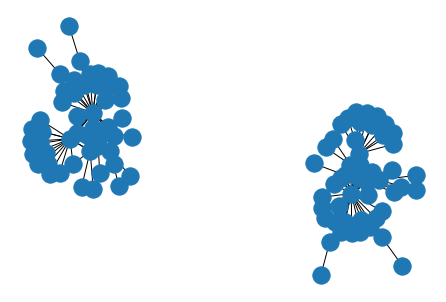

In [5]:
#Generate two disjoint graphs
n = 50
#g_1 = nx.fast_gnp_random_graph(n,0.125,seed=0)
#g_2 = nx.fast_gnp_random_graph(n,0.125,seed=0)
g_1 = nx.scale_free_graph(n,seed=0)
g_2 = nx.scale_free_graph(n,seed=0)
g_1 = g_1.to_undirected()
g_2 = g_2.to_undirected()
g = nx.disjoint_union(g_1,g_2)
nx.draw(g)
#pos = nx.planar_layout(g)
#nx.draw(g,pos)

In [6]:
#Add 10% more nodes that aren't connected
for i in range(np.int(2*n/10)):
    g.add_node(2*n+i)

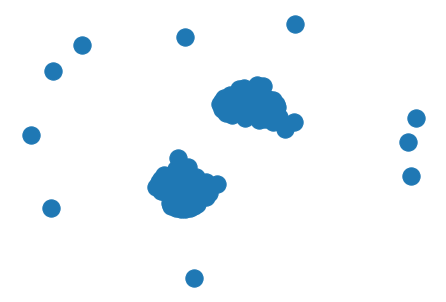

In [7]:
nx.draw(g)

In [8]:
np.random.seed(0)

#Randomly connect the original two graphs via the newly created disjoint nodes, 
#one edge to a random node in each graph for each node
for i in range(np.int(2*n/10)):
    g.add_edge(2*n+i,np.random.randint(0,n))
    g.add_edge(2*n+i,np.random.randint(n,2*n))

#Embed it in R2
pos=nx.fruchterman_reingold_layout(g)

g = nx.Graph(g)

In [9]:
node_colors = []

for i in range(2*n):
    node_colors.append('teal')

for i in range(2*n,len(g.nodes)):
    node_colors.append('red')

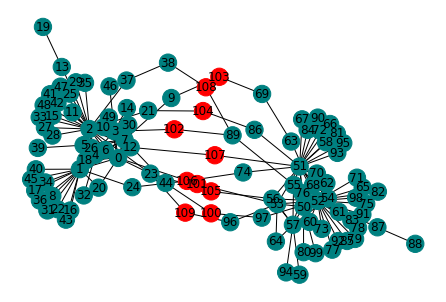

In [10]:
nx.draw(g,pos,with_labels=True,node_color=node_colors)

# Skeleton

In [11]:
resolution_skele = 0.1 #Resolution is the width of each bin
gain_skele = 8/10 #Gain is the overlap between bins

In [12]:
mapper_skele = myMapper(resolution_skele,gain_skele)

C:\Users\Jack\anaconda3\lib\site-packages\sklearn\cluster\_spectral.py:482: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"
C:\Users\Jack\anaconda3\lib\site-packages\scipy\sparse\linalg\eigen\arpack\arpack.py:1592: RuntimeWarning: k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.
  RuntimeWarning)
C:\Users\Jack\anaconda3\lib\site-packages\sklearn\cluster\_spectral.py:482: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"
C:\Users\Jack\anaconda3\lib\site-packages\scipy\sparse\linalg\eigen\arpack\arpack.py:1592: RuntimeWarning: k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh

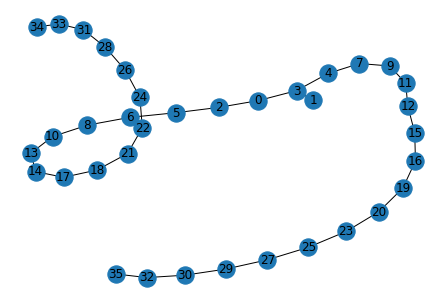

In [13]:
mapper_skele.nodeFramer(g,2) #Obtain coordinates and filter values
mapped_skele = mapper_skele.graphDrawer() #Make the MAPPER result

In [14]:
big_cluster = [3]
immunisation_nodes = mapper_skele.nodeReturner(big_cluster)
n_immunised = len(immunisation_nodes)

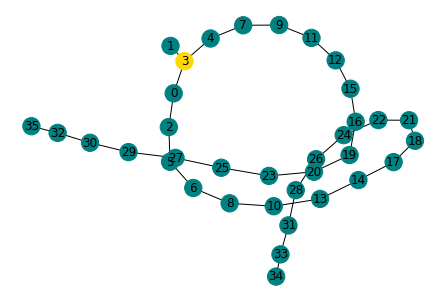

In [15]:
colors = ['teal']*len(mapped_skele.nodes)

for i in big_cluster:
    colors[i] = 'gold'
    
nx.draw(mapped_skele,with_labels=True,node_color=colors)

In [16]:
test = infectionGrapher(g)
n_iters = 100
trans_P = 0.05

n_trials = 500

## Immunised based on Mapper clustering

In [17]:
for i in range(n_trials):
    test.reset()
    test.infector(n_iters,trans_P,immunised=immunisation_nodes,draw_graph=False,plot_homology=False,print_Fin=False)
    
    listExtender(test.myInfecData,n_iters)
    
    if i == 0:
        mapped_immunisation_timeline = np.array(test.myInfecData)
    else:
        mapped_immunisation_timeline += np.array(test.myInfecData)
        
mapped_immunisation_timeline = mapped_immunisation_timeline / n_trials

## Immunised by choosing the smallest Katz Centrality values

In [18]:
ordered_centralities = []
centralities = nx.katz_centrality(g)

for i in range(len(centralities)):
    ordered_centralities.append(centralities[i])
    
ordered_centralities.sort()
ordered_immunised = []

for i in range(n_immunised):
    value = ordered_centralities.pop(0)
    
    for j in centralities:
        if centralities[j] == value:
            ordered_immunised.append(j)

for i in range(n_trials):
    test.reset()
    test.infector(n_iters,trans_P,immunised=ordered_immunised,draw_graph=False,plot_homology=False,print_Fin=False)

    listExtender(test.myInfecData,n_iters)

    if i == 0:
        ordered_immunisation_timeline = np.array(test.myInfecData)
    else:
        ordered_immunisation_timeline += np.array(test.myInfecData)
        
ordered_immunisation_timeline = ordered_immunisation_timeline / n_trials

## Immunised Randomly

In [19]:
for i in range(n_trials):
    random_immunised = random.sample(g.nodes,n_immunised)
    test.reset()
    test.infector(n_iters,trans_P,immunised=random_immunised,draw_graph=False,plot_homology=False,print_Fin=False)

    listExtender(test.myInfecData,n_iters)

    if i == 0:
        random_immunisation_timeline = np.array(test.myInfecData)
    else:
        random_immunisation_timeline += np.array(test.myInfecData)
        
random_immunisation_timeline = random_immunisation_timeline / n_trials

## No Immunisation

In [20]:
for i in range(n_trials):
    test.reset()
    test.infector(n_iters,trans_P,draw_graph=False,plot_homology=False,print_Fin=False)
    
    listExtender(test.myInfecData,n_iters)
    
    if i == 0:
        no_immunisation_timeline = np.array(test.myInfecData)
    else:
        no_immunisation_timeline += np.array(test.myInfecData)
        
no_immunisation_timeline = no_immunisation_timeline / n_trials

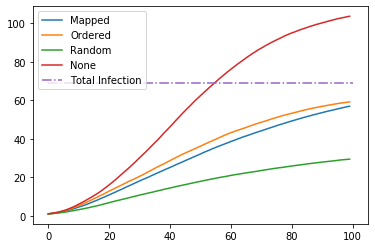

In [21]:
plt.plot(mapped_immunisation_timeline)
plt.plot(ordered_immunisation_timeline)
plt.plot(random_immunisation_timeline)
plt.plot(no_immunisation_timeline)
plt.plot([0,n_iters],[len(mapper_skele.nodes)-n_immunised,len(mapper_skele.nodes)-n_immunised],linestyle='-.')
plt.legend(['Mapped','Ordered','Random','None','Total Infection'])

# Checking Nodes

In [22]:
immune_colors = ['teal'] * len(g.nodes)

for i in immunisation_nodes:
    immune_colors[i] = 'green'

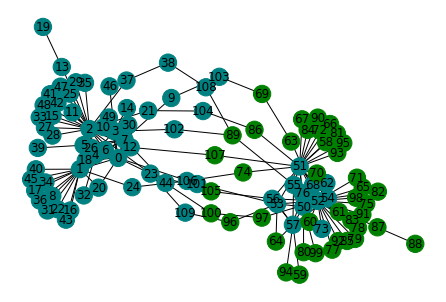

In [23]:
nx.draw(g,pos,node_color=immune_colors,with_labels=True)

In [24]:
answer_nodes = mapper_skele.clusterReturner([100,101,102,103,104,105,106,107,108,109])

In [25]:
answer_colors = ['teal'] * len(mapped_skele.nodes)

for i in answer_nodes:
    answer_colors[i] = 'green'

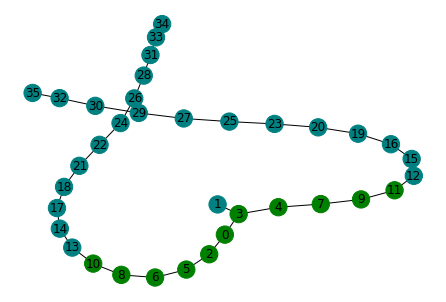

In [26]:
nx.draw(mapped_skele,node_color=answer_colors,with_labels=True)

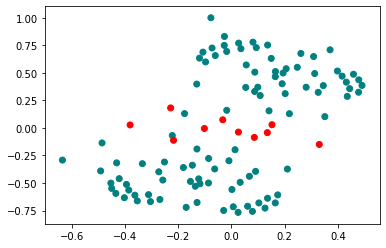

In [27]:
plt.scatter(mapper_skele.nodes['x'],mapper_skele.nodes['y'],c=node_colors)